## Gene HD saturation modelling

For random subsets of the TCGA samples, count how many unique gene HDs are observed.

In [1]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
import itertools
import re
import sys
sys.path.append("../1_data_processing")
import warnings
warnings.simplefilter("ignore")

import graphing_params as gp
import processing_utils as util
%load_ext autoreload
%autoreload 1
%aimport graphing_params
%aimport processing_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_genes = get_local_data_path(['processed'], 'HGNC_gene_annot_ens93_hg19.csv')
file_ascat_summary = get_data_path(['TCGA','ASCATv3_SNP6_hg19'],'summary.ascatv3TCGA.penalty70.hg19.tsv')
file_pcawg_samples = get_data_path(['PCAWG'], 'pcawg_donors_tableS1.xlsx')
folder_hd_maps = lambda fname: get_local_data_path(['processed','HD_maps'], fname)
file_tcga_outliers = get_local_data_path(['processed','TCGA','ASCAT'], 'outlier_samples.csv')
file_icgc_outliers = get_local_data_path(['processed','ICGC'], 'outlier_samples.csv')

### Load data

In [2]:
genes = pd.read_csv(file_genes)
passenger_genes = genes[~genes.TSG & ~genes.OG & ~genes.within_driver & ~genes.outside_bounds]
print('N genes:', genes.shape[0], passenger_genes.shape[0])

N genes: 17572 16898


In [3]:
tcga_hd_map = util.deserialize_map(folder_hd_maps("tcga_hd_map.csv"))

In [4]:
icgc_hd_map = util.deserialize_map(folder_hd_maps("icgc_hd_map.csv"))

In [5]:
tcga_gene_hds = util.count_dels_per_gene(tcga_hd_map, genes)

In [6]:
icgc_gene_hds = util.count_dels_per_gene(icgc_hd_map, genes)

In [7]:
comb_gene_hds = pd.merge(tcga_gene_hds, icgc_gene_hds[['symbol','n_del']], on=['symbol'])
comb_gene_hds['n_del'] = comb_gene_hds.n_del_x + comb_gene_hds.n_del_y

In [8]:
print('TCGA: Genes deleted (1+):', sum(tcga_gene_hds.n_del>0))
print('ICGC: Genes deleted (1+):', sum(icgc_gene_hds.n_del>0))
print('Combined: Genes deleted (1+):', sum(comb_gene_hds.n_del>0))

TCGA: Genes deleted (1+): 6012
ICGC: Genes deleted (1+): 2092
Combined: Genes deleted (1+): 6745


In [9]:
ascat_summary_all = pd.read_csv(file_ascat_summary, sep='\t')
ascat_summary = ascat_summary_all[(ascat_summary_all['QC']=='Pass')]
tcga_outliers = pd.read_csv(file_tcga_outliers)
ascat_summary = ascat_summary[~ascat_summary.patient.isin(tcga_outliers.patient)]
print('N TCGA samples (minus outliers):', ascat_summary.patient.nunique())

N TCGA samples (minus outliers): 9951


In [10]:
sample_list = pd.read_excel(file_pcawg_samples, engine='openpyxl', skiprows=2)
icgc_samples = sample_list[sample_list.tcga_donor_uuid.isna()].reset_index(drop=True)
icgc_outliers = pd.read_csv(file_icgc_outliers)
icgc_samples = icgc_samples[~icgc_samples.icgc_donor_id.isin(icgc_outliers.icgc_donor_id)]
print('N ICGC samples (minus outliers):', icgc_samples.icgc_donor_id.nunique())

N ICGC samples (minus outliers): 1774


### Sub-sample TCGA samples, count all gene HDs

In [11]:
# For reproducibility
random.seed(15)
randomlist = random.sample(range(0, 150), 100)

In [19]:
hds_est = {key:[] for key in range(1000,10000,1000)}
for n in hds_est.keys():
    for i in range(0,100):
        samples_subset = ascat_summary.patient.sample(n=n, replace=False, random_state=randomlist[i])
        gene_hds = util.count_dels_per_gene(tcga_hd_map[tcga_hd_map.patient.isin(samples_subset)], genes)
        hds_est[n].append(sum(gene_hds.n_del>0)) # Count number of genes deleted in this subset of samples
hds_est_df = pd.DataFrame(hds_est)

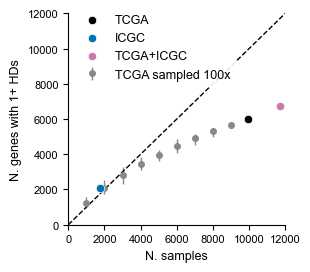

In [21]:
f, ax = plt.subplots(1, 1, figsize=(2.8,2.8))
df = pd.melt(hds_est_df, var_name='n_samples', value_name='n_gene_hds')
means = df.groupby('n_samples').n_gene_hds.mean()

# args: x, y, yerr=difference from mean (error amount, not absolute)
ax.errorbar(df.n_samples.unique(), means, 
            [means-df.groupby('n_samples').n_gene_hds.min(), df.groupby('n_samples').n_gene_hds.max()-means], 
            linestyle='None', marker='o', ms=4, color='#888', elinewidth=1, label='TCGA sampled 100x')

sns.scatterplot([ascat_summary.shape[0]], [sum(tcga_gene_hds.n_del>0)], color='black', label='TCGA')

sns.scatterplot([icgc_samples.shape[0]], [sum(icgc_gene_hds.n_del>0)], color=gp.get_color('blue'), zorder=3, label='ICGC')

sns.scatterplot([ascat_summary.shape[0]+icgc_samples.shape[0]], [sum(comb_gene_hds.n_del>0)], 
                color=gp.get_color('pink'), zorder=3, label='TCGA+ICGC')

ax.set_xlim([0,12000]); ax.set_ylim([0,12000]);
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='k')
gp.set_axis_props(ax, xlabel='N. samples', ylabel='N. genes with 1+ HDs')
ax.legend(loc='upper left', bbox_to_anchor=(0,1.05))
plt.savefig('../figures/saturation_analysis.png', bbox_inches='tight', dpi=500)